# Environment Setup
In case of no kernels / setup done

In [3]:
# from IPython.display import clear_output
# !pip install datasets transformers tqdm pandas numpy accelerate matplotlib qwen-vl-utils transformer-utils
# clear_output()

# Initial Setup
Setting up RunPod-based cache storing, and importing libraries

In [4]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface/'

In [5]:
import torch
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from PIL import Image
from qwen_vl_utils import process_vision_info

/workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Mock VLMs
Please change the importing to your preferred VLMs loader~

In [6]:
MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

In [7]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    device_map="auto",
).eval()
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=True, padding_side="left")

`torch_dtype` is deprecated! Use `dtype` instead!
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 3294.82it/s]


# Prepping inputs

In [8]:
image_path = "../files/img1.png"
image = Image.open(image_path).convert("RGB")

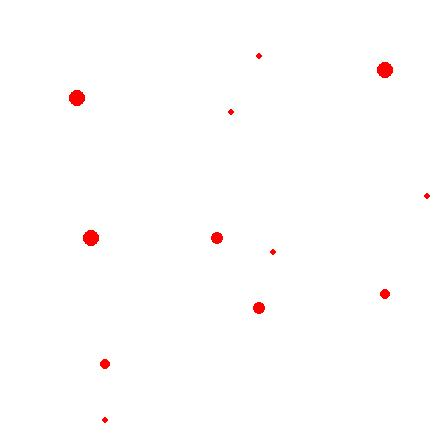

In [9]:
image.show()

In [10]:
model

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

In [13]:
# prompt = "Look at the image and tell me what you see?"
prompt = "How many dots are in the image?"
image_path = "../files/img1.png"
image = Image.open(image_path).convert("RGB")

messages = [
    # {"role": "system", "content": ""},
    {"role": "user", "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt}
    ]}
]

image_inputs, _ = process_vision_info(messages)

input_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
input_text = input_text.replace("system\n", "")

inputs = processor(
    text=[input_text],
    images=image_inputs,
    return_tensors="pt",
    padding=True
).to(model.device)

In [14]:
outputs = model.generate(
    **inputs,
    max_new_tokens=1500,
    output_hidden_states=True,
    return_dict_in_generate=True,
    do_sample=False,
    pad_token_id=processor.tokenizer.eos_token_id
)

generated_text = processor.tokenizer.decode(
    outputs.sequences[0],
    skip_special_tokens=True
)

print(generated_text)

You are a helpful assistant.
user
How many dots are in the image?
 addCriterion
The image contains 13 dots.


In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'DejaVu Sans'

def logit_lens_generated_tokens_all(model, processor, outputs):
    hidden_states_per_step = outputs.hidden_states
    num_generated_tokens = len(hidden_states_per_step)
    
    if num_generated_tokens == 0:
        return [], []
    
    num_layers = len(hidden_states_per_step[0])
    
    tokens_matrix = [[] for _ in range(num_layers)]  # layers x generated_tokens
    probs_matrix = [[] for _ in range(num_layers)]   # layers x generated_tokens
    
    final_norm = getattr(model.model.language_model, "norm", None)
    layer_norms = []
    for i in range(num_layers):
        try:
            if hasattr(model.model.language_model, 'layers') and i < len(model.model.language_model.layers):
                layer_norm = getattr(model.model.language_model.layers[i], "post_attention_layernorm", None)
                layer_norms.append(layer_norm)
            else:
                layer_norms.append(None)
        except:
            layer_norms.append(None)
    
    for step_idx in range(num_generated_tokens):
        step_hidden_states = hidden_states_per_step[step_idx]
        
        for layer_idx in range(num_layers):
            layer_hidden_state = step_hidden_states[layer_idx]
            if isinstance(layer_hidden_state, tuple):
                layer_hidden_state = layer_hidden_state[0]
            
            vec = layer_hidden_state[0, -1, :]
            
            if layer_idx == num_layers - 1:
                if final_norm is not None:
                    vec = final_norm(vec)
            else:
                next_layer_idx = layer_idx
                if next_layer_idx < len(layer_norms) and layer_norms[next_layer_idx] is not None:
                    vec = layer_norms[next_layer_idx](vec)
                elif layer_idx < len(layer_norms) and layer_norms[layer_idx] is not None:
                    vec = layer_norms[layer_idx](vec)
            
            logits = model.lm_head(vec)
            probs = torch.softmax(logits, dim=-1)
            top_idx = torch.argmax(probs)
            print(f"LAYER {layer_idx} TOP IDX", top_idx, "PROBS", probs[top_idx].item())
            
            token_str = processor.tokenizer.decode([top_idx.item()])
            tokens_matrix[layer_idx].append(token_str)
            probs_matrix[layer_idx].append(probs[top_idx].item())
    
    return tokens_matrix, probs_matrix

def plot_generated_logit_lens(tokens_matrix, probs_matrix, actual_generated_tokens=None):
    if not tokens_matrix or not tokens_matrix[0]:
        print("No tokens to plot!")
        return
    
    num_layers = len(tokens_matrix)
    num_generated_tokens = len(tokens_matrix[0])
    
    prob_array = np.array(probs_matrix)
    
    plt.figure(figsize=(max(num_generated_tokens*1.5, 20), max(num_layers*0.3, 4)))
    im = plt.imshow(prob_array, cmap="viridis", aspect='auto', origin='lower')
    cbar = plt.colorbar(im)
    cbar.set_label("Probability of most confident token")
    
    x_labels = [f"Gen{i+1}" for i in range(num_generated_tokens)]
    if actual_generated_tokens is not None:
        x_labels = [f"Gen{i+1}\n({tok})" for i, tok in enumerate(actual_generated_tokens[:num_generated_tokens])]
    
    plt.xticks(ticks=np.arange(num_generated_tokens), labels=x_labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(ticks=np.arange(num_layers), labels=[f"L{i}" for i in range(num_layers)], fontsize=12)
    
    plt.xlabel("Generated Token Position")
    plt.ylabel("Model Layer")
    plt.title("Logit-Lens: Token Predictions Across Layers During Generation")
    
    for layer_idx in range(num_layers):
        for token_idx in range(num_generated_tokens):
            token_text = tokens_matrix[layer_idx][token_idx]
            display_text = token_text
            
            plt.text(token_idx, layer_idx, display_text, 
                    ha='center', va='center', fontsize=10,
                    color='white' if prob_array[layer_idx, token_idx] < 0.5 else 'black',
                    weight='bold')
    
    plt.tight_layout()
    plt.show()

def get_actual_generated_tokens(processor, outputs, input_length):
    generated_sequence = outputs.sequences[0]  # First (and only) sequence
    generated_tokens = generated_sequence[input_length:]  # Remove input tokens
    return [processor.tokenizer.decode([token]) for token in generated_tokens]


LAYER 0 TOP IDX tensor(44243, device='cuda:0') PROBS 2.5272369384765625e-05
LAYER 1 TOP IDX tensor(2073, device='cuda:0') PROBS 0.0089111328125
LAYER 2 TOP IDX tensor(7, device='cuda:0') PROBS 0.001068115234375
LAYER 3 TOP IDX tensor(95525, device='cuda:0') PROBS 0.0015411376953125
LAYER 4 TOP IDX tensor(151646, device='cuda:0') PROBS 0.00118255615234375
LAYER 5 TOP IDX tensor(135411, device='cuda:0') PROBS 0.00775146484375
LAYER 6 TOP IDX tensor(118228, device='cuda:0') PROBS 0.0001239776611328125
LAYER 7 TOP IDX tensor(127045, device='cuda:0') PROBS 2.9802322387695312e-05
LAYER 8 TOP IDX tensor(113056, device='cuda:0') PROBS 3.457069396972656e-05
LAYER 9 TOP IDX tensor(139913, device='cuda:0') PROBS 0.0001811981201171875
LAYER 10 TOP IDX tensor(44243, device='cuda:0') PROBS 5.2928924560546875e-05
LAYER 11 TOP IDX tensor(103161, device='cuda:0') PROBS 4.410743713378906e-05
LAYER 12 TOP IDX tensor(117806, device='cuda:0') PROBS 3.457069396972656e-05
LAYER 13 TOP IDX tensor(124743, devi

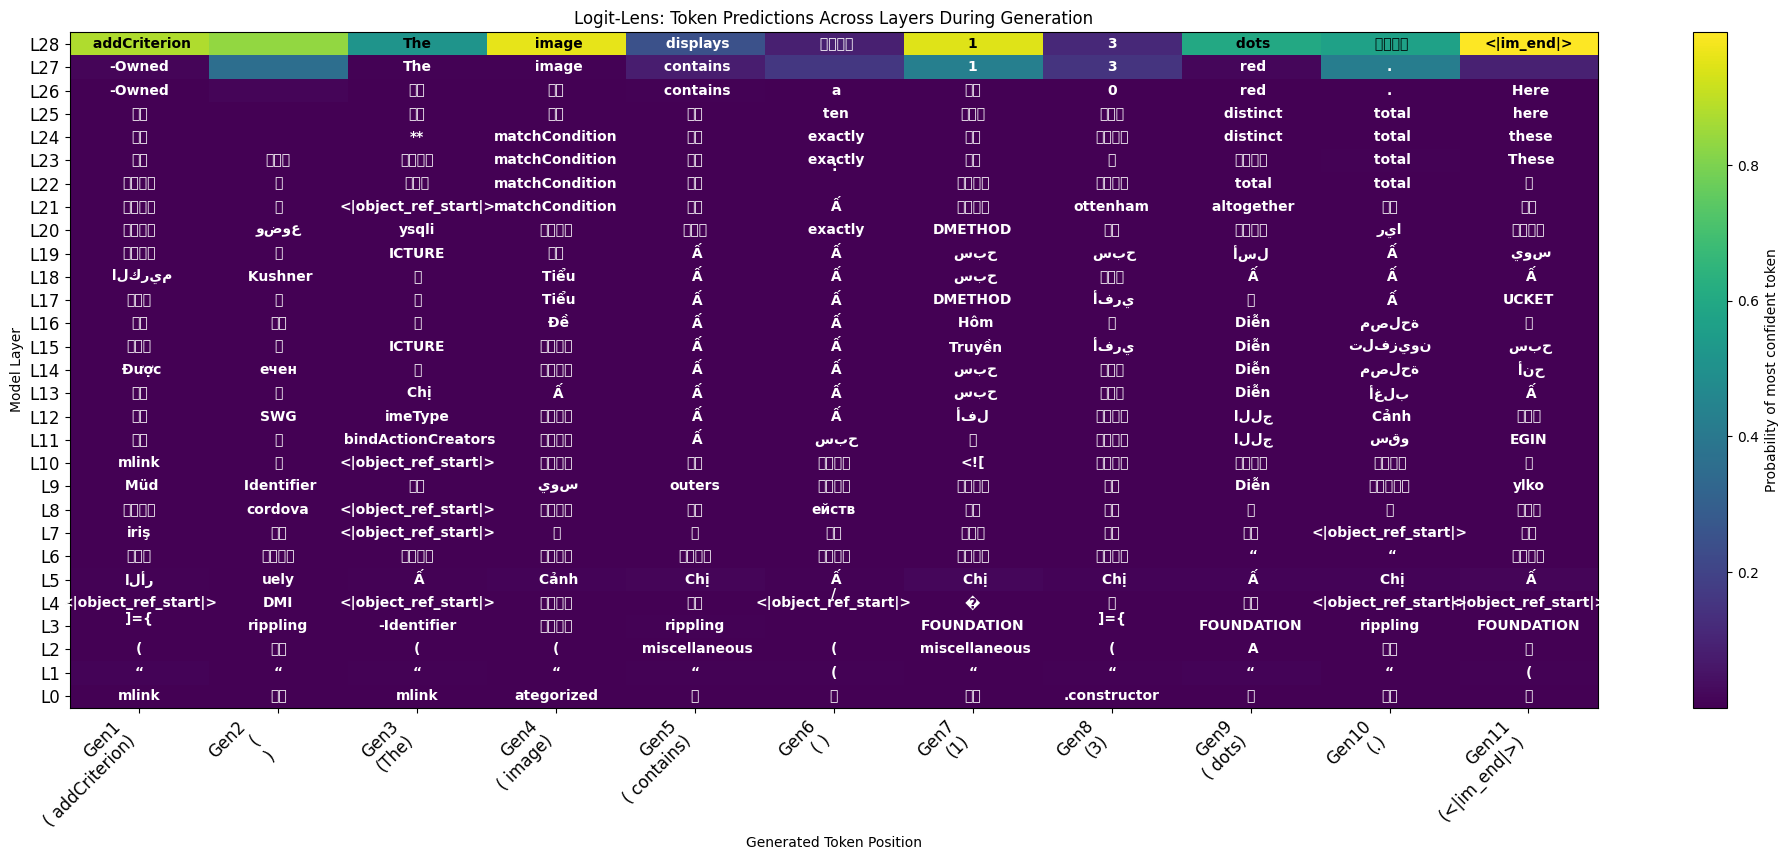

In [24]:
with torch.no_grad():
    input_length = inputs['input_ids'].shape[1]
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=15,
        output_hidden_states=True,
        return_dict_in_generate=True,
        do_sample=False,
        pad_token_id=processor.tokenizer.eos_token_id
    )

generated_text = processor.tokenizer.decode(
    outputs.sequences[0],
    skip_special_tokens=True
)
tokens_matrix, probs_matrix = logit_lens_generated_tokens_all(model, processor, outputs)
actual_tokens = get_actual_generated_tokens(processor, outputs, input_length)

plot_generated_logit_lens(tokens_matrix, probs_matrix, actual_tokens)

In [ ]:
with torch.no_grad():
    input_length = inputs['input_ids'].shape[1]
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=15,
        output_hidden_states=True,
        return_dict_in_generate=True,
        do_sample=False,
        pad_token_id=processor.tokenizer.eos_token_id
    )

generated_text = processor.tokenizer.decode(
    outputs.sequences[0],
    skip_special_tokens=True
)
tokens_matrix, probs_matrix = logit_lens_generated_tokens_all(model, processor, outputs)
actual_tokens = get_actual_generated_tokens(processor, outputs, input_length)

plot_generated_logit_lens(tokens_matrix, probs_matrix, actual_tokens)